<a href="https://colab.research.google.com/github/AleksandrRevuka/HW_Data_Science/blob/main/Hw9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Adamax, Ftrl
from keras.datasets import fashion_mnist
from keras.layers import Dropout

In [3]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.clf()
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

In [4]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

train_data, test_data = train_data / 255., test_data / 255.

4422102/4422102 [==============================] - 0s 0us/step


In [25]:
clothing_classes = 10
n_hidden_1 = 64
n_hidden_2 = 128
n_hidden_3 = 256
epochs = 10

In [6]:
def build_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(n_hidden_3, activation='relu'),
        Dense(n_hidden_2, activation='relu'),
        Dense(n_hidden_1, activation='relu'),
        Dense(clothing_classes, activation='softmax'),
    ])

    model.compile(
        optimizer=Adamax(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [26]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               200960    
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 10)                650       
                                                                 
Total params: 242762 (948.29 KB)
Trainable params: 242762 (948.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
history = model.fit(train_data, train_labels, epochs=epochs, validation_split=0.4, validation_data=(test_data, test_labels))


Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.5207 - accuracy: 0.8178 - val_loss: 0.4458 - val_accuracy: 0.8429
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3827 - accuracy: 0.8619 - val_loss: 0.4030 - val_accuracy: 0.8590
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3430 - accuracy: 0.8745 - val_loss: 0.3798 - val_accuracy: 0.8630
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3157 - accuracy: 0.8836 - val_loss: 0.3605 - val_accuracy: 0.8687
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2934 - accuracy: 0.8918 - val_loss: 0.3495 - val_accuracy: 0.8736
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2801 - accuracy: 0.8965 - val_loss: 0.3431 - val_accuracy: 0.8751
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2654 - accuracy: 0.9024 - val_loss: 0.3376 - val_ac

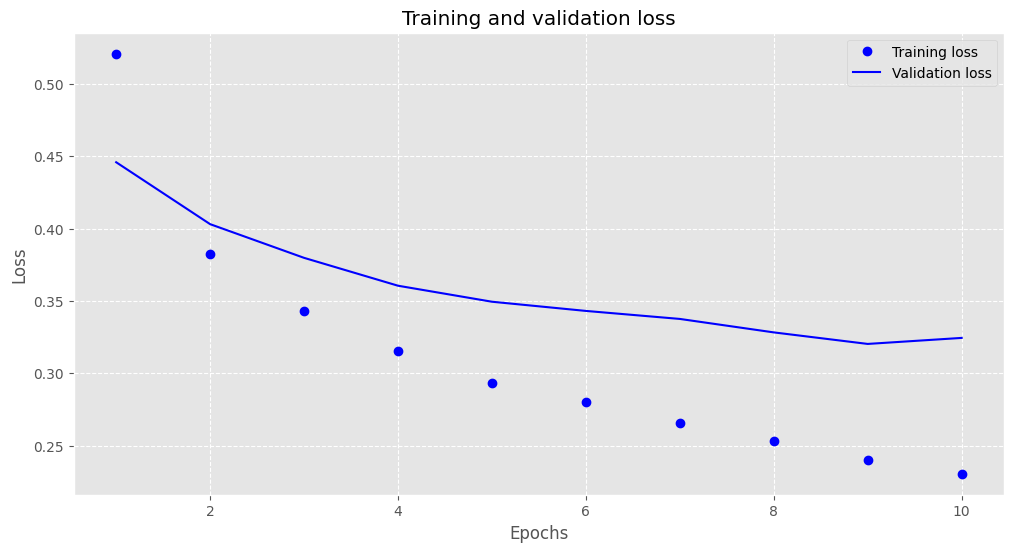

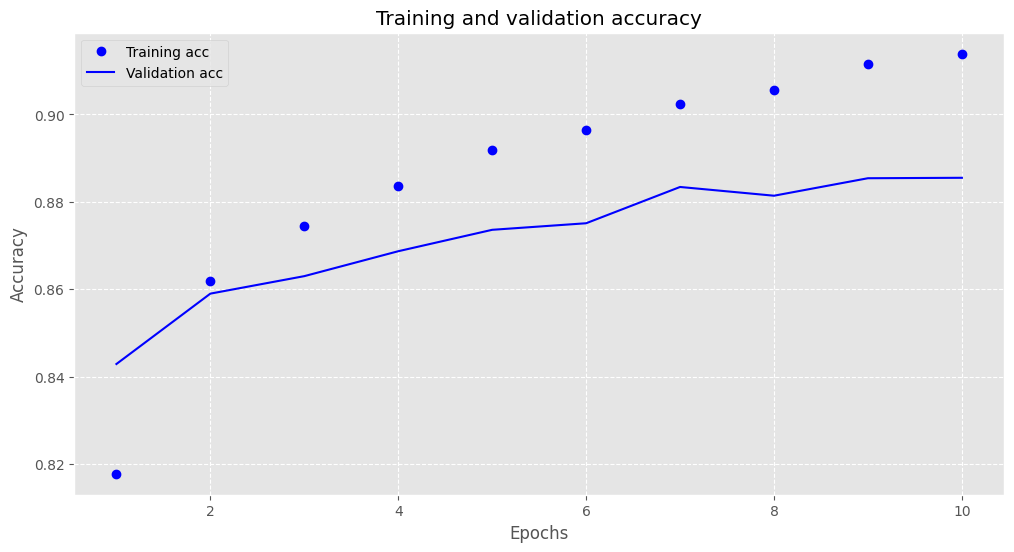

In [28]:
plot_history(history)

In [29]:
results = model.evaluate(test_data, test_labels)
print(results)

313/313 [==============================] - 1s 2ms/step - loss: 0.3245 - accuracy: 0.8855
[0.3244706988334656, 0.8855000138282776]
